# HoVer-Net Output Notebook

This repository enables the segmentation of nuclei in H&E whole-slide images (WSIs). For inference, we have incorporated two modes:

- Tile processing mode
- WSI processing mode (out of scope for our task)

For tile processing, the input must be in a standard image format, such as `.jpg` or `.png`. <br />
For WSI processing, the input must be an [OpenSlide](https://openslide.org/) supported whole-slide image. (out of scope for our task)

- Both tile and wsi processing modes output a `.json` file that contains:
        - bounding box coordinates for each nucleus
        - centroid coordinates for each nucleus
        - contour coordinates for each nucleus 
        - nucleus type predictions
        - per class probabilities for each nucleus (optional)
- tile mode also output a `.mat` and overlay file. The `.mat` file contains:
        - raw output of network (optional)
        - instance map containing values from 0 to N, where N is the number of nuclei
        - list of length N containing predictions for each nucleus
- wsi mode also produces a low resolution thumbnail and a tissue mask

In this notebook, we demonstrate how to utilise the output generated by these two different settings.

In [9]:
# load the libraries

import sys
sys.path.append('../')

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import scipy.io as sio
import cv2
import json

from misc.wsi_handler import get_file_handler
from misc.viz_utils import visualize_instances_dict

In [42]:
import logging
#MAKE SURE THAT THE PATH LINKED THE FOLDER CONTAINING OPENSLIDE DLL FILES OTHERWISE IMPORT WILL FAIL
os.environ['PATH'] = r'C:\Users\user\Documents\MIE 1517H\Project\openslide-win64-20171122\bin' + os.pathsep + os.environ['PATH']
import cv2
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.utils import io as IPyIO
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 300

# adding the project root folder
sys.path.append('../')
from tiatoolbox.models import IOSegmentorConfig, SemanticSegmentor
from tiatoolbox.utils.visualization import overlay_prediction_contours

from misc.utils import cropping_center, recur_find_ext, rm_n_mkdir, rmdir

In [43]:
from pathlib import Path 
#path for this work folder, TODO: need to fix later
script_dir=Path("__file__").parent.absolute().parent


# Random seed for deterministic
SEED = 5
# The number of nuclei within the dataset/predictions.
# For CoNIC, we have 6 (+1 for background) types in total.
NUM_TYPES = 7
# The path to the directory containg images.npy etc.
DATA_DIR = script_dir.joinpath('data')
# The path to the pretrained weights
PRETRAINED = script_dir.joinpath('pretrained/hovernet-conic.pth')
# The path to contain output and intermediate processing results
OUT_DIR = script_dir.joinpath('exp_output')

# TODO: other paths to be checked

tile_path = '../dataset/sample_tiles/imgs/'
tile_json_path = '../dataset/sample_tiles/pred/json/'
tile_mat_path = '../dataset/sample_tiles/pred/mat/'
tile_overlay_path = '../dataset/sample_tiles/pred/overlay/'

# Generating Data Splits

Here, we show how the training data is split into the training and validation subsets. The CoNIC training data comes from multiple sources. To ensure that we have a balanced dataset, we use stratified sampling according to the data source.

For the baseline model, we utilize 80% the number of patches for training and the remaining for validation. However, because we apply stratified sampling according to the origin, the final number of patches may not be 80/20 (each image may contain a different number of patches). Therefore, we generate a number of splits (indicated via the NUM_TRIALS variable) and select the one that has the number of patches that most closely matches with our expected ratio.

Lastly, to ensure the reproducibility of the sampling, we also provide a random seed.

In [44]:
NUM_TRIALS = 10  # number of splits to be generated
TRAIN_SIZE = 0.8
VALID_SIZE = 0.2

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit

info = pd.read_csv(f'{DATA_DIR}/patch_info.csv')
file_names = np.squeeze(info.to_numpy()).tolist()

img_sources = [v.split('-')[0] for v in file_names]
img_sources = np.unique(img_sources)

cohort_sources = [v.split('_')[0] for v in img_sources]
_, cohort_sources = np.unique(cohort_sources, return_inverse=True)

splitter = StratifiedShuffleSplit(
    n_splits=NUM_TRIALS,
    train_size=TRAIN_SIZE,
    test_size=VALID_SIZE,
    random_state=SEED
)

splits = []
split_generator = splitter.split(img_sources, cohort_sources)
for train_indices, valid_indices in split_generator:
    train_cohorts = img_sources[train_indices]
    valid_cohorts = img_sources[valid_indices]
    assert np.intersect1d(train_cohorts, valid_cohorts).size == 0
    train_names = [
        file_name
        for file_name in file_names
        for source in train_cohorts
        if source == file_name.split('-')[0]
    ]
    valid_names = [
        file_name
        for file_name in file_names
        for source in valid_cohorts
        if source == file_name.split('-')[0]
    ]
    train_names = np.unique(train_names)
    valid_names = np.unique(valid_names)
    print(f'Train: {len(train_names):04d} - Valid: {len(valid_names):04d}')
    assert np.intersect1d(train_names, valid_names).size == 0
    train_indices = [file_names.index(v) for v in train_names]
    valid_indices = [file_names.index(v) for v in valid_names]
    splits.append({
        'train': train_indices,
        'valid': valid_indices
    })
joblib.dump(splits, f"{OUT_DIR}/splits.dat")

Train: 3963 - Valid: 1018
Train: 4053 - Valid: 0928
Train: 3952 - Valid: 1029
Train: 3988 - Valid: 0993
Train: 3997 - Valid: 0984
Train: 4002 - Valid: 0979
Train: 3894 - Valid: 1087
Train: 4012 - Valid: 0969
Train: 3988 - Valid: 0993
Train: 3964 - Valid: 1017


['c:\\Users\\user\\Documents\\MIE 1517H\\Project\\Hover_net_implementation\\hover_net\\exp_output/splits.dat']

# Convert .npy files as individual .npy files

This is to be done as the run_infer/run_train takes individual .npys

In [69]:
# TODO: fix the path
FOLD_IDX = 0

train_indices = t_v_splits[FOLD_IDX]['train']
valid_indices = t_v_splits[FOLD_IDX]['valid']

for idx in train_indices:
    img = imgs[idx]
    np.save(rf'C:\Users\user\Documents\MIE 1517H\Project\Hover_net_implementation\hover_net\data\conic\train\{idx:04d}.npy',img)

for idx in valid_indices:
    img = imgs[idx]
    np.save(rf'C:\Users\user\Documents\MIE 1517H\Project\Hover_net_implementation\hover_net\data\conic\valid\{idx:04d}.npy',img)



In [6]:
import numpy as np
test1 = np.load(r"C:\Users\user\Documents\MIE 1517H\Project\Hover_net_implementation\hover_net\dataset\training_data\consep\consep\train\540x540_164x164\train_1_000.npy")

In [18]:
imgtest1 = test1[:,:,:3]

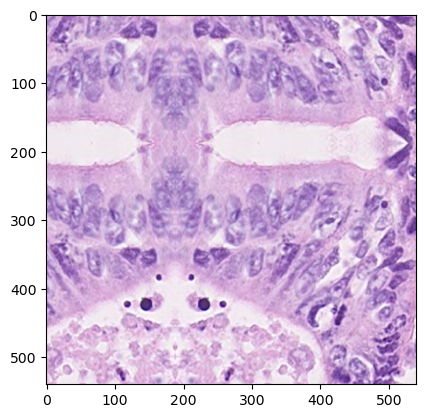

In [20]:
import matplotlib.pyplot as plt
plt.imshow(imgtest1)
plt.show()

In [16]:
# The fold to use
FOLD_IDX = 0

In [ ]:
imgs = np.load(f'{DATA_DIR}/images.npy')
labels = np.load(f'{DATA_DIR}/labels.npy')

splits = joblib.load(f'{OUT_DIR}/splits.dat')
valid_indices = splits[FOLD_IDX]['valid']

rm_n_mkdir(f'{OUT_DIR}/imgs/')
for idx in valid_indices:
    img = imgs[idx]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'{OUT_DIR}/imgs/{idx:04d}.png', img)

valid_labels = labels[valid_indices]
np.save(f'{OUT_DIR}/valid_true.npy', valid_labels)